In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

In [4]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))

In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv(r"C:\Users\Sazzad Ansari\Desktop\SkinCancerDetection\SkinCancerDetection\data\HAM10000\HAM10000_metadata.csv")
data['image_full_name'] = data['image_id'] + '.jpg'
X = data[['image_full_name', 'lesion_id']]

encoder = LabelEncoder()
Y = encoder.fit_transform(data['dx'])  # Labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.17, random_state=42)

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

Y_train_df = pd.DataFrame(Y_train, columns=['dx'])

Y_train_df['dx'] = Y_train_df['dx'].astype(str)

train_df = pd.concat([X_train.reset_index(drop=True), Y_train_df], axis=1)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="C:\\Users\\Sazzad Ansari\\Desktop\\SkinCancerDetection\\SkinCancerDetection\\data\\HAM10000\\HAM10000_images",
    x_col="image_full_name",
    y_col="dx",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 8312 validated image filenames belonging to 7 classes.


In [8]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.0001)

In [9]:
sgd = SGD(learning_rate=0.01, clipvalue=0.5)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.17, random_state=42)

Y_train_df = pd.DataFrame(Y_train, columns=['dx'])
Y_val_df = pd.DataFrame(Y_val, columns=['dx'])

Y_train_df['dx'] = Y_train_df['dx'].astype(str)
Y_val_df['dx'] = Y_val_df['dx'].astype(str)

train_df = pd.concat([X_train.reset_index(drop=True), Y_train_df], axis=1)
val_df = pd.concat([X_val.reset_index(drop=True), Y_val_df], axis=1)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="C:\\Users\\Sazzad Ansari\\Desktop\\SkinCancerDetection\\SkinCancerDetection\\data\\HAM10000\\\\HAM10000_images",
    x_col="image_full_name",
    y_col="dx",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1703 validated image filenames belonging to 7 classes.


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30
259/259 [==============================] - 956s 4s/step - loss: 1.0119 - accuracy: 0.6600 - val_loss: 2.1806 - val_accuracy: 0.6616
Epoch 2/30
259/259 [==============================] - 936s 4s/step - loss: 0.7701 - accuracy: 0.7245 - val_loss: 3.5975 - val_accuracy: 0.6627
Epoch 3/30
259/259 [==============================] - 889s 3s/step - loss: 0.6813 - accuracy: 0.7591 - val_loss: 1.5201 - val_accuracy: 0.6639
Epoch 4/30
259/259 [==============================] - 877s 3s/step - loss: 0.6324 - accuracy: 0.7762 - val_loss: 1.6533 - val_accuracy: 0.6769
Epoch 5/30
259/259 [==============================] - 876s 3s/step - loss: 0.5699 - accuracy: 0.7998 - val_loss: 3.2862 - val_accuracy: 0.6633
Epoch 6/30
259/259 [==============================] - 876s 3s/step - loss: 0.5303 - accuracy: 0.8112 - val_loss: 1.0923 - val_accuracy: 0.7081
Epoch 7/30
259/259 [==============================] - 875s 3s/step - loss: 0.4799 - accuracy: 0.8273 - val_loss: 4.7916 - val_accuracy: 0.6651

In [ ]:
import warnings
warnings.filterwarnings("ignore")
model.save('skincancerdetectionmodel.h5')

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


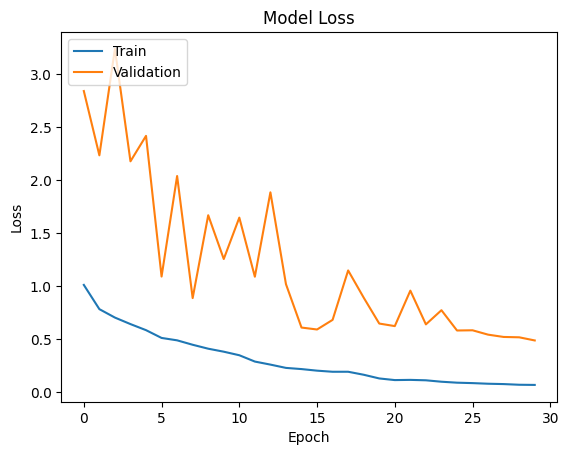

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)

if isinstance(X_test, pd.DataFrame):
    X_test = X_test.reset_index(drop=True)

if isinstance(Y_test, np.ndarray):
    Y_test = pd.DataFrame(Y_test)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.concat([X_test, Y_test], axis=1),
    directory="C:\\Users\\Sazzad Ansari\\Desktop\\SkinCancerDetection\\SkinCancerDetection\\data\\HAM10000\\HAM10000_images",
    x_col="image_full_name",
    y_col="dx",
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode=None)

predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = np.argmax(predictions, axis=1)

Found 1703 validated image filenames.
1703/1703 [==============================] - 59s 34ms/step


In [26]:
report = classification_report(Y_test, y_pred, target_names=encoder.classes_)
print(report)

              precision    recall  f1-score   support

       akiec       1.00      0.16      0.28        62
         bcc       0.84      0.60      0.70        77
         bkl       0.44      0.76      0.56       201
          df       0.81      0.54      0.65        24
         mel       0.24      0.73      0.36       191
          nv       0.94      0.55      0.70      1128
        vasc       0.81      0.85      0.83        20

    accuracy                           0.59      1703
   macro avg       0.72      0.60      0.58      1703
weighted avg       0.80      0.59      0.63      1703



In [28]:
model.save('skincancerdetectionmodel.h5')